In [312]:
!pip install matplotlib


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\jdobe\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [313]:
import yfinance as yf
import numpy as np
import arch
import matplotlib.pyplot as plt

In [314]:
ticker = "^GSPC"
data = yf.download(ticker, start="1960-01-01", end="2023-01-01")

C:\Users\jdobe\AppData\Local\Temp\ipykernel_3548\2793084089.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="1960-01-01", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed


In [315]:
print(data.head())
print(data.shape)

Price           Close       High        Low       Open   Volume
Ticker          ^GSPC      ^GSPC      ^GSPC      ^GSPC    ^GSPC
Date                                                           
1960-01-04  59.910000  59.910000  59.910000  59.910000  3990000
1960-01-05  60.389999  60.389999  60.389999  60.389999  3710000
1960-01-06  60.130001  60.130001  60.130001  60.130001  3730000
1960-01-07  59.689999  59.689999  59.689999  59.689999  3310000
1960-01-08  59.500000  59.500000  59.500000  59.500000  3290000
(15858, 5)


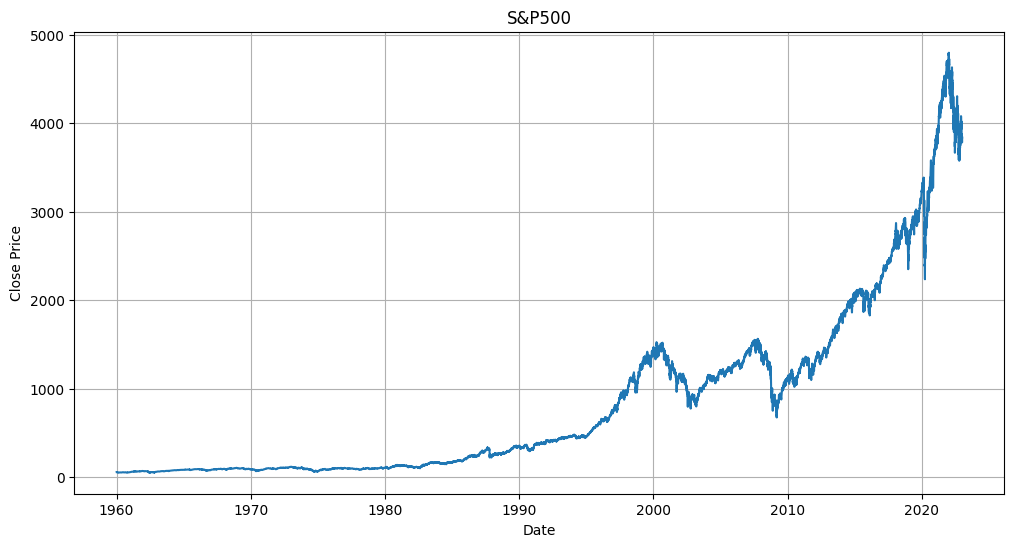

In [316]:
plt.figure(figsize=(12, 6))
plt.plot(data['Close'])
plt.title('S&P500')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

## Feature Engineering

In [317]:
# Create variable Log Returns and further
data["DailyReturn"] = np.log(data["Close"]).diff()
data = data.iloc[1:]

In [318]:
data.head()

Price,Close,High,Low,Open,Volume,DailyReturn
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,
Date,,,,,,
1960-01-05,60.389999,60.389999,60.389999,60.389999,3710000,0.007980
1960-01-06,60.130001,60.130001,60.130001,60.130001,3730000,-0.004315
1960-01-07,59.689999,59.689999,59.689999,59.689999,3310000,-0.007344
1960-01-08,59.500000,59.500000,59.500000,59.500000,3290000,-0.003188
1960-01-11,58.770000,58.770000,58.770000,58.770000,3470000,-0.012345


## GARCH(1,1) Model for Volatility Forecast



In [319]:
model = arch.arch_model(data["DailyReturn"]*1000, vol="GARCH", p=1, q=1)
model_fit = model.fit()
print(model_fit.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 923796090312.3402
Iteration:      2,   Func. Count:     14,   Neg. LLF: 12188402.664294241
Iteration:      3,   Func. Count:     21,   Neg. LLF: 56316.15451782483
Iteration:      4,   Func. Count:     27,   Neg. LLF: 56192.376620714
Iteration:      5,   Func. Count:     33,   Neg. LLF: 5583550820.0031395
Iteration:      6,   Func. Count:     39,   Neg. LLF: 56370.391117195555
Iteration:      7,   Func. Count:     45,   Neg. LLF: 56169.7555719136
Iteration:      8,   Func. Count:     51,   Neg. LLF: 56178.99098546479
Iteration:      9,   Func. Count:     57,   Neg. LLF: 56157.648427601016
Iteration:     10,   Func. Count:     62,   Neg. LLF: 56157.628385307726
Iteration:     11,   Func. Count:     67,   Neg. LLF: 56157.628269854904
Iteration:     12,   Func. Count:     72,   Neg. LLF: 56157.628261777616
Iteration:     13,   Func. Count:     76,   Neg. LLF: 56157.62826177861
Optimization terminated successfully    (Exit mode 0)
      

In [320]:
data['GARCH_volatility'] = model_fit.conditional_volatility
data.head()

Price,Close,High,Low,Open,Volume,DailyReturn,GARCH_volatility
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,,
Date,,,,,,,
1960-01-05,60.389999,60.389999,60.389999,60.389999,3710000,0.007980,7.376043
1960-01-06,60.130001,60.130001,60.130001,60.130001,3730000,-0.004315,7.429550
1960-01-07,59.689999,59.689999,59.689999,59.689999,3310000,-0.007344,7.262138
1960-01-08,59.500000,59.500000,59.500000,59.500000,3290000,-0.003188,7.365763
1960-01-11,58.770000,58.770000,58.770000,58.770000,3470000,-0.012345,7.138952


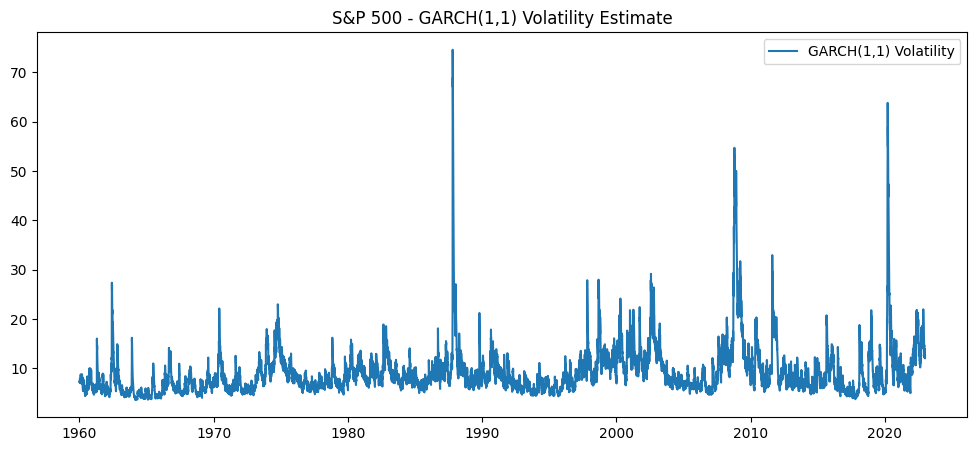

In [321]:
plt.figure(figsize=(12,5))
plt.plot(data['GARCH_volatility'], label='GARCH(1,1) Volatility')
plt.title('S&P 500 - GARCH(1,1) Volatility Estimate')
plt.legend()
plt.show()

## Reproducing results from [Christofferson and Diebold](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=453803)

In [322]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

## 1 day asset return sign forecast

In [323]:
# # Prepare features and target
# data = data.copy()
# data['Sign'] = (data['DailyReturn'].shift(-1) > 0).astype(int)
# data['inv_vol'] = 1 / data['GARCH_volatility']
# window_size = 1250  # e.g., use 500 days for training
# test_size = 9000    # number of rolling predictions

# preds = []
# actuals = []
# indices = []
# probabilities = {}

# for i in range(window_size, window_size + test_size):
#     train_X = data['inv_vol'].iloc[i-window_size:i].values.reshape(-1, 1)
#     train_y = data['Sign'].iloc[i-window_size:i].values
#     test_X = data['inv_vol'].iloc[i].reshape(1, -1)
#     test_y = data['Sign'].iloc[i]
    
#     model = LogisticRegression(solver='liblinear')
#     model.fit(train_X, train_y)
#     pred = model.predict(test_X)[0]
#     prob = model.predict_proba(test_X)[0][1]
#     probabilities[data.index[i]] = prob
    
#     preds.append(pred)
#     actuals.append(test_y)
#     indices.append(data.index[i])

# results = pd.DataFrame({'Actual': actuals, 'Predicted': preds}, index=indices)
# print("Accuracy:", accuracy_score(results['Actual'], results['Predicted']))
# print(classification_report(results['Actual'], results['Predicted']))
# avg = np.mean(list(probabilities.values()))
# proba_series = pd.Series(probabilities)

# plt.figure(figsize=(12, 4))
# plt.plot(proba_series.index, proba_series.values, label='Logit Probability (P[Sign=1])')
# plt.title('Conditional Probability of Positive S&P 500 Return')
# plt.xlabel('Date')
# plt.ylabel('Probability')
# plt.ylim(0, 1)
# plt.axhline(y=avg, color='r', linestyle='--', label='Average Probability')
# plt.legend()
# plt.tight_layout()
# plt.show()

## 5 day asset return sign forecast

In [324]:
# # Create 5-day ahead sign target

# data['WeeklyReturn'] = np.log(data['Close']).diff(5)
# data['Sign_5d'] = (data['WeeklyReturn'] > 0).astype(int)
# data['inv_vol'] = 1 / data['GARCH_volatility']

# window_size = 1250
# test_size = 10000

# preds_5d = []
# actuals_5d = []
# indices_5d = []
# probabilities_5d = {}

# for i in range(window_size, window_size + test_size):
#     train_X = data['inv_vol'].iloc[i-window_size:i].values.reshape(-1, 1)
#     train_y = data['Sign_5d'].iloc[i-window_size:i].values
#     test_X = data['inv_vol'].iloc[i].reshape(1, -1)
#     test_y = data['Sign_5d'].iloc[i]
    
#     model = LogisticRegression(solver='liblinear')
#     model.fit(train_X, train_y)
#     pred = model.predict(test_X)[0]
#     prob = model.predict_proba(test_X)[0][1]
#     probabilities_5d[data.index[i]] = prob
    
#     preds_5d.append(pred)
#     actuals_5d.append(test_y)
#     indices_5d.append(data.index[i])

# results_5d = pd.DataFrame({'Actual': actuals_5d, 'Predicted': preds_5d}, index=indices_5d)


# # Plot probability time series
# proba_series_5d = pd.Series(probabilities_5d)
# plt.figure(figsize=(12, 4))
# plt.plot(proba_series_5d.index, proba_series_5d.values, label='Logit Probability (P[Sign_5d=1])')
# plt.title('Conditional Probability of Positive S&P 500 Return (weekly)')
# plt.xlabel('Date')
# plt.ylabel('Probability')
# plt.ylim(0, 1)
# plt.axhline(y=proba_series_5d.mean(), color='r', linestyle='--', label='Average Probability')
# plt.legend()
# plt.tight_layout()
# plt.show()

### Daily, Weekly, Monthly, Quarterly, Semiannual and Yearly sign predictions

Accuracy: 0.512
              precision    recall  f1-score   support

           0       0.48      0.22      0.30      4803
           1       0.52      0.78      0.62      5197

    accuracy                           0.51     10000
   macro avg       0.50      0.50      0.46     10000
weighted avg       0.50      0.51      0.47     10000



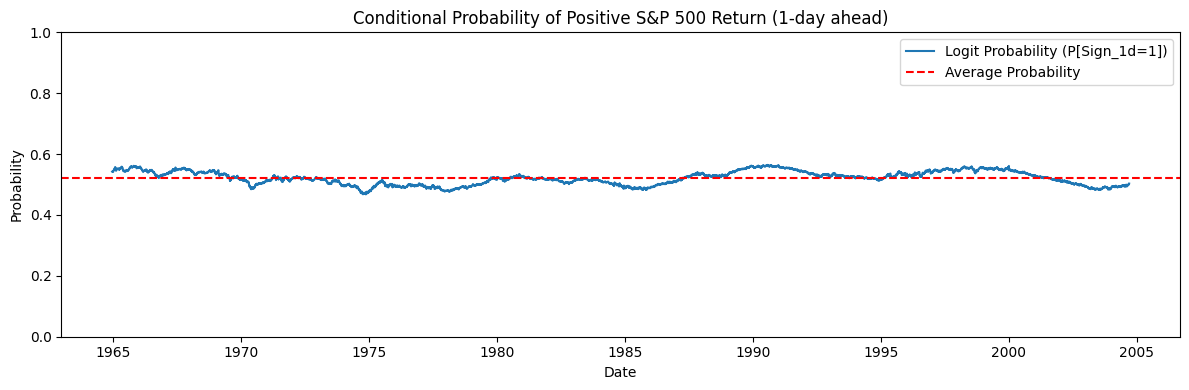

Accuracy: 0.5433
              precision    recall  f1-score   support

           0       0.48      0.13      0.21      4522
           1       0.55      0.88      0.68      5478

    accuracy                           0.54     10000
   macro avg       0.52      0.51      0.44     10000
weighted avg       0.52      0.54      0.47     10000



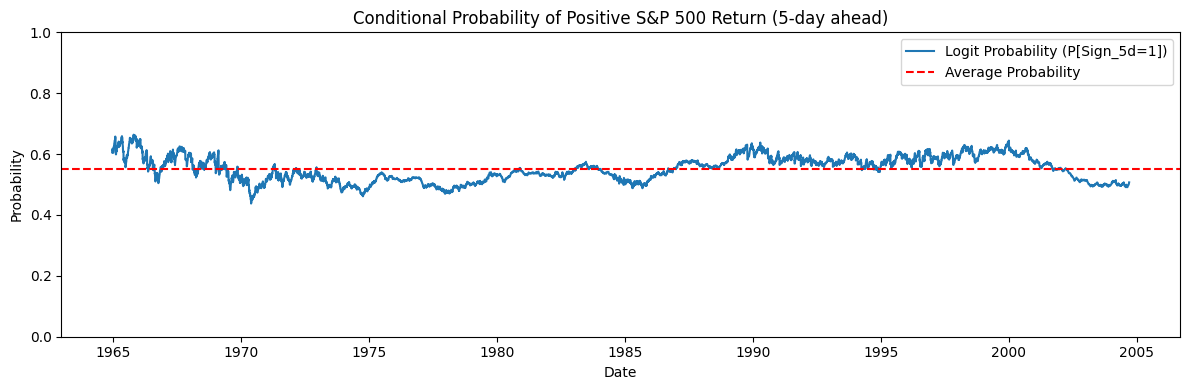

Accuracy: 0.6007
              precision    recall  f1-score   support

           0       0.56      0.19      0.28      4160
           1       0.61      0.89      0.72      5840

    accuracy                           0.60     10000
   macro avg       0.58      0.54      0.50     10000
weighted avg       0.59      0.60      0.54     10000



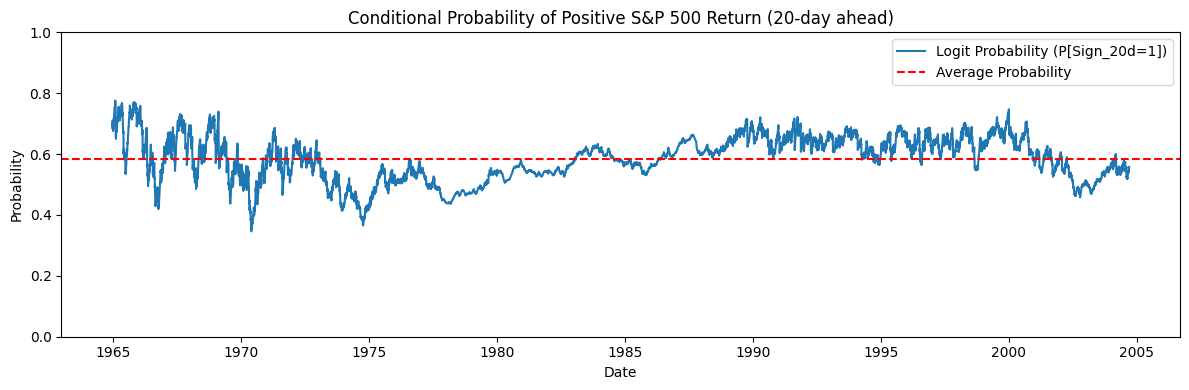

Accuracy: 0.6629
              precision    recall  f1-score   support

           0       0.64      0.24      0.35      3772
           1       0.67      0.92      0.77      6228

    accuracy                           0.66     10000
   macro avg       0.65      0.58      0.56     10000
weighted avg       0.66      0.66      0.61     10000



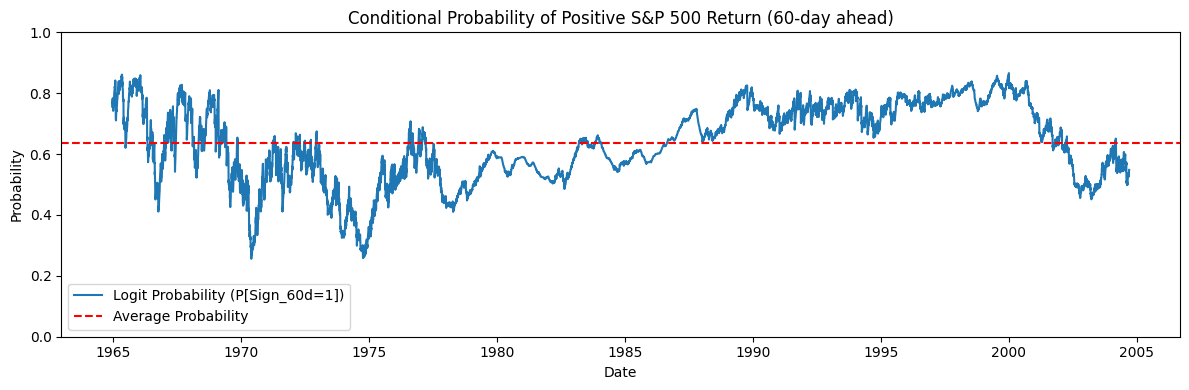

Accuracy: 0.693
              precision    recall  f1-score   support

           0       0.63      0.27      0.38      3448
           1       0.71      0.91      0.80      6552

    accuracy                           0.69     10000
   macro avg       0.67      0.59      0.59     10000
weighted avg       0.68      0.69      0.65     10000



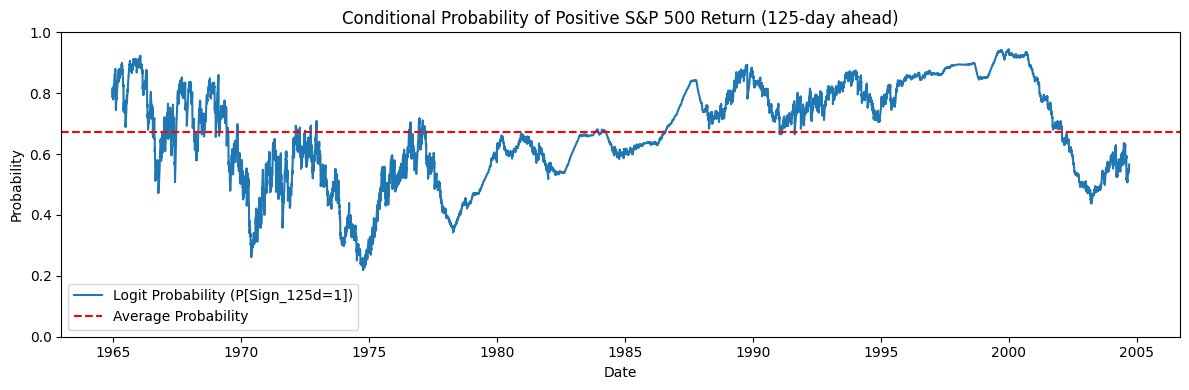

Accuracy: 0.743
              precision    recall  f1-score   support

           0       0.69      0.23      0.34      2929
           1       0.75      0.96      0.84      7071

    accuracy                           0.74     10000
   macro avg       0.72      0.59      0.59     10000
weighted avg       0.73      0.74      0.69     10000



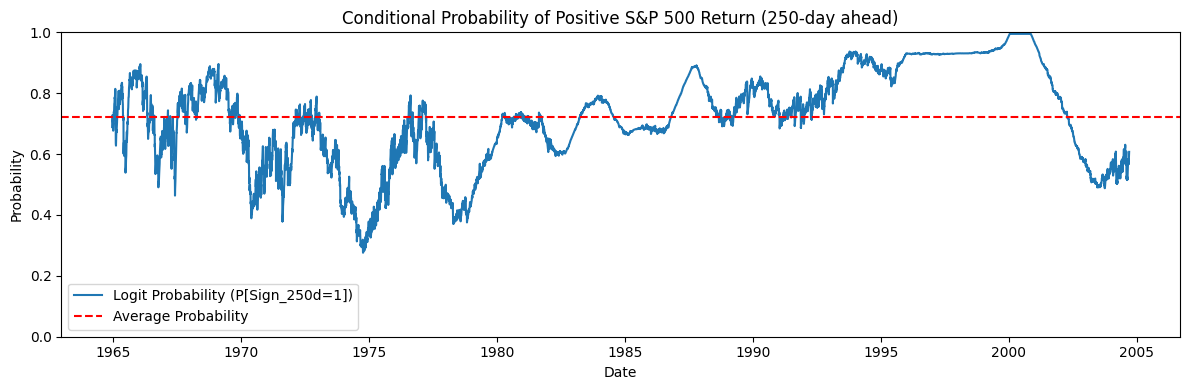

In [325]:
window_size = 1250  ## training samples
test_size = 10000   ## rolling predictions
data['inv_vol'] = 1 / data['GARCH_volatility']

# 1, 5, 20, 60, 120 and 250 day ahead sign targets
for horizon in [1, 5, 20, 60, 125, 250]:
    data[f"{horizon}d_Return"] = np.log(data['Close']).diff(horizon)
    sign_col = f'Sign_{horizon}d'
    data[sign_col] = (data[f"{horizon}d_Return"] > 0).astype(int)
    data_h = data.copy()

    preds_h = []
    actuals_h = []
    indices_h = []
    probabilities_h = {}

    for i in range(window_size, window_size + test_size):
        train_X = data_h['inv_vol'].iloc[i-window_size:i].values.reshape(-1, 1)
        train_y = data_h[sign_col].iloc[i-window_size:i].values
        test_X = data_h['inv_vol'].iloc[i].reshape(1, -1)
        test_y = data_h[sign_col].iloc[i]

        model = LogisticRegression(solver='liblinear')
        model.fit(train_X, train_y)
        pred = model.predict(test_X)[0]
        prob = model.predict_proba(test_X)[0][1]
        probabilities_h[data_h.index[i]] = prob

        preds_h.append(pred)
        actuals_h.append(test_y)
        indices_h.append(data_h.index[i])

    results_h = pd.DataFrame({'Actual': actuals_h, 'Predicted': preds_h}, index=indices_h)
    print("Accuracy:", accuracy_score(results_h['Actual'], results_h['Predicted']))
    print(classification_report(results_h['Actual'], results_h['Predicted']))
    proba_series_h = pd.Series(probabilities_h)

    plt.figure(figsize=(12, 4))
    plt.plot(proba_series_h.index, proba_series_h.values, label=f'Logit Probability (P[Sign_{horizon}d=1])')
    plt.title(f'Conditional Probability of Positive S&P 500 Return ({horizon}-day ahead)')
    plt.xlabel('Date')
    plt.ylabel('Probability')
    plt.ylim(0, 1)
    plt.axhline(y=proba_series_h.mean(), color='r', linestyle='--', label='Average Probability')
    plt.legend()
    plt.tight_layout()
    plt.show()

## Building Neural Net for Sign Prediction
Using the volatility, we want now to predict the sign of asset returns for different time horizons.